## Summary

This notebook is used to generate various overview plots of the autism phenotype dataset.
* Pie chart of response (0, 1, 2, 3, ...) distribution
* Pie charts of clinical diagnosis, ADIR diagnosis, ADOS diagnosis, and SRS diagnosis
* Pie charts showing clinical diagnosis for males and females separately
* Counts for instrument venn diagram (image generated using eulerAPE http://www.eulerdiagrams.org/eulerAPE/)
* Pie chart of datasets
* Pie chart of sex
* Bar chart of age
* Bar chart of missing data per feature
* Listing of item types for ADIR
* Listing of item types for ADOS
* Listing of item types for SRS



## Load Data

In [370]:
import json
import csv
import numpy as np
  
filename = '../data/all_samples_ordinal'
with open("%s.csv" % filename) as f:
    reader = csv.reader(f)
    header = next(reader)[1:]
    sample_names, data = zip(*[(x[0], x[1:]) for x in reader])
    
data = np.asarray(data)
data[data == 'None'] = -1
data = data.astype(int)
print(data.shape)

with open("%s_labels.csv" % filename) as f:
    reader = csv.reader(f)
    label_header = next(reader)[1:]
    _, labels = zip(*[(x[0], x[1:]) for x in reader])
    

(43684, 1013)


In [371]:
# Check that there are no empty rows
no_data = np.where(np.all(data==-1, axis=1))[0]
print(no_data.shape, no_data)

(0,) []


## Instruments

In [372]:
from collections import defaultdict

with open('../data/all_samples.json', 'r') as f:
    # Read in samples
    samples = json.load(f)

one_way_counts = defaultdict(int)
two_way_counts = defaultdict(int)
for s in samples:
    instruments = sorted([k for k, v in s.items() if isinstance(v, dict)])
    for i, inst1 in enumerate(instruments):
        one_way_counts[inst1] += 1
        for j in range(i+1, len(instruments)):
            inst2 = instruments[j]
            two_way_counts[(inst1, inst2)] += 1
#print(one_way_counts)
#print(two_way_counts)
    
    
    
            

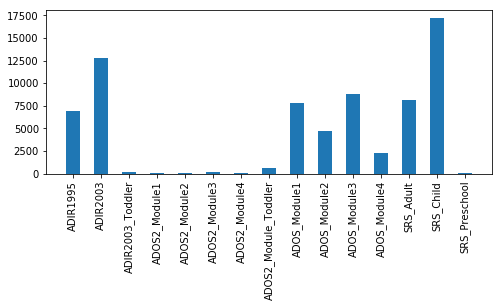

In [373]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))

inst = sorted(one_way_counts.keys())
width = 0.5

r0 = [one_way_counts[k] for k in inst]

plt.bar(inst, r0, width)
plt.xticks(range(len(inst)), inst, rotation='vertical')
plt.show()


//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
//anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


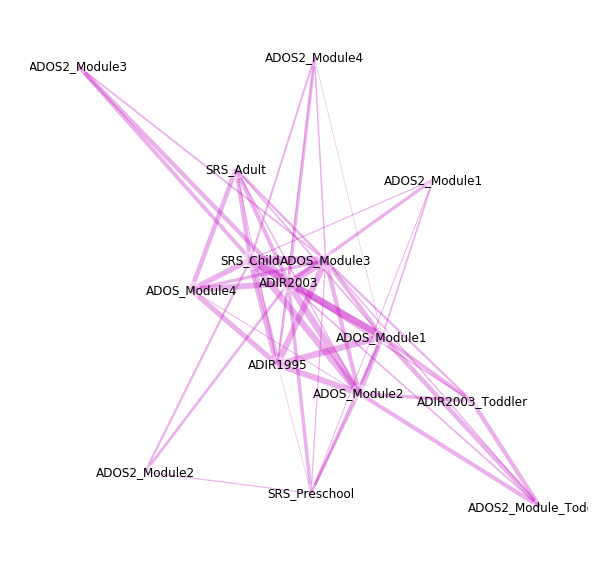

In [374]:
import networkx as nx
import math

plt.figure(figsize=(10, 10))

G = nx.Graph()
G.add_nodes_from(one_way_counts.keys())
for (i1, i2), w in two_way_counts.items():
    G.add_edge(i1, i2, weight=math.log10(w))
    
edgewidth = []
for (u, v, d) in G.edges(data=True):
    edgewidth.append(2*G.get_edge_data(u, v)['weight'])
    
pos = nx.spring_layout(G, iterations=200)
nx.draw_networkx_edges(G, pos, alpha=0.3, width=edgewidth, edge_color='m')
nx.draw_networkx_nodes(G, pos, node_color='w', alpha=0.4)
nx.draw_networkx_labels(G, pos, fontsize=14)
plt.axis('off')
plt.show()

## Responses

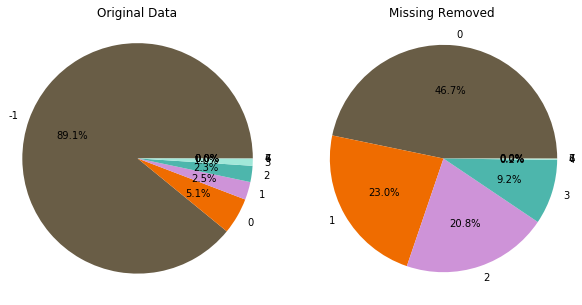

In [375]:
import matplotlib.pyplot as plt
unique, counts = np.unique(data, return_counts=True)
value_to_counts = dict(zip(unique, counts))
unique = sorted(unique)
counts = [value_to_counts[u] for u in unique]
colors = ["#695d46", "#ef6c00", "#ce93d8", "#4db6ac", "#a1e8d9"]
#dict(zip(unique, counts/sum(counts)))

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.pie(counts/sum(counts), labels=unique, autopct='%1.1f%%', colors=colors)
ax1.set_title('Original Data')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

del counts[unique.index(-1)]
del unique[unique.index(-1)]
ax2.pie(counts/sum(counts), labels=unique, autopct='%1.1f%%', colors=colors)
ax2.set_title('Missing Removed')
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## Diagnosis

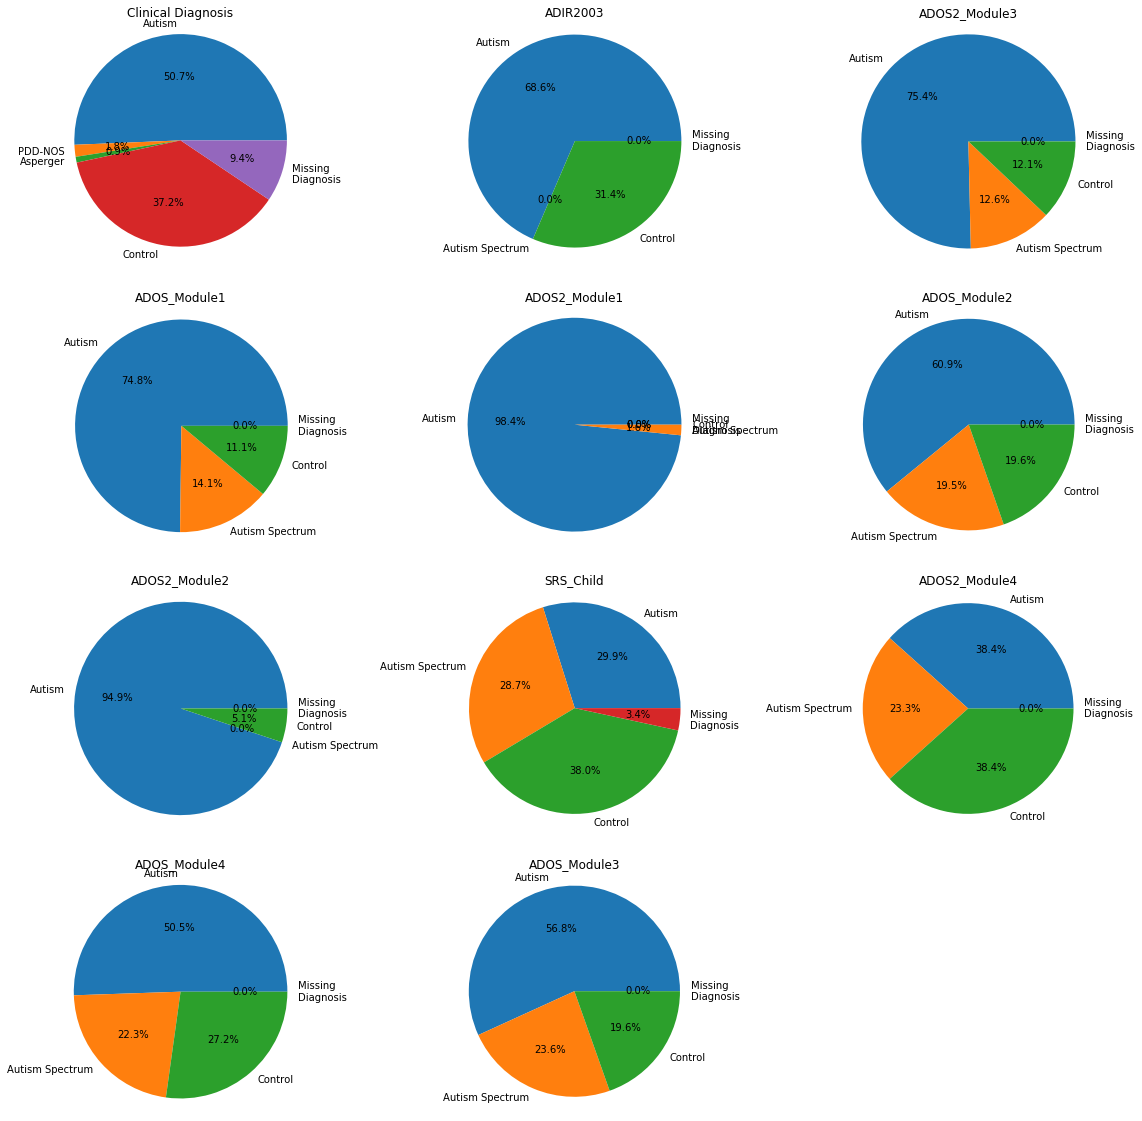

In [376]:
import matplotlib.pyplot as plt
from collections import Counter

plt.figure(figsize=(20, 20))
instrument_diag_to_counts = defaultdict(int)
instrs = set()
for i, s in enumerate(samples):
    instruments = sorted([k for k, v in s.items() if isinstance(v, dict)])
    for inst in instruments:
        if inst + ':diagnosis' in label_header:
            diag = labels[i][label_header.index(inst + ':diagnosis')]
            instrument_diag_to_counts[(inst, diag)] += 1
            instrs.add(inst)

keys = ['Autism', 'Autism Spectrum', 'Control', 'None']
clin_keys = ['Autism', 'PDD-NOS', 'Asperger', 'Control', 'None']

# clinical
plt.subplot(4, 3, 1)
plt.title('Clinical Diagnosis')
c = Counter([x[label_header.index('clinical_diagnosis')] for x in labels])
plt.pie([c[k] for k in clin_keys], labels=[k if k != 'None' else 'Missing\nDiagnosis' for k in clin_keys], autopct='%1.1f%%')
plt.axis('equal')

for i, inst in enumerate(instrs):
    plt.subplot(4, 3, i+2)
    plt.title(inst)
    plt.pie([instrument_diag_to_counts[(inst, k)] for k in keys], labels=[k if k != 'None' else 'Missing\nDiagnosis' for k in keys], autopct='%1.1f%%')
    plt.axis('equal')

plt.show()


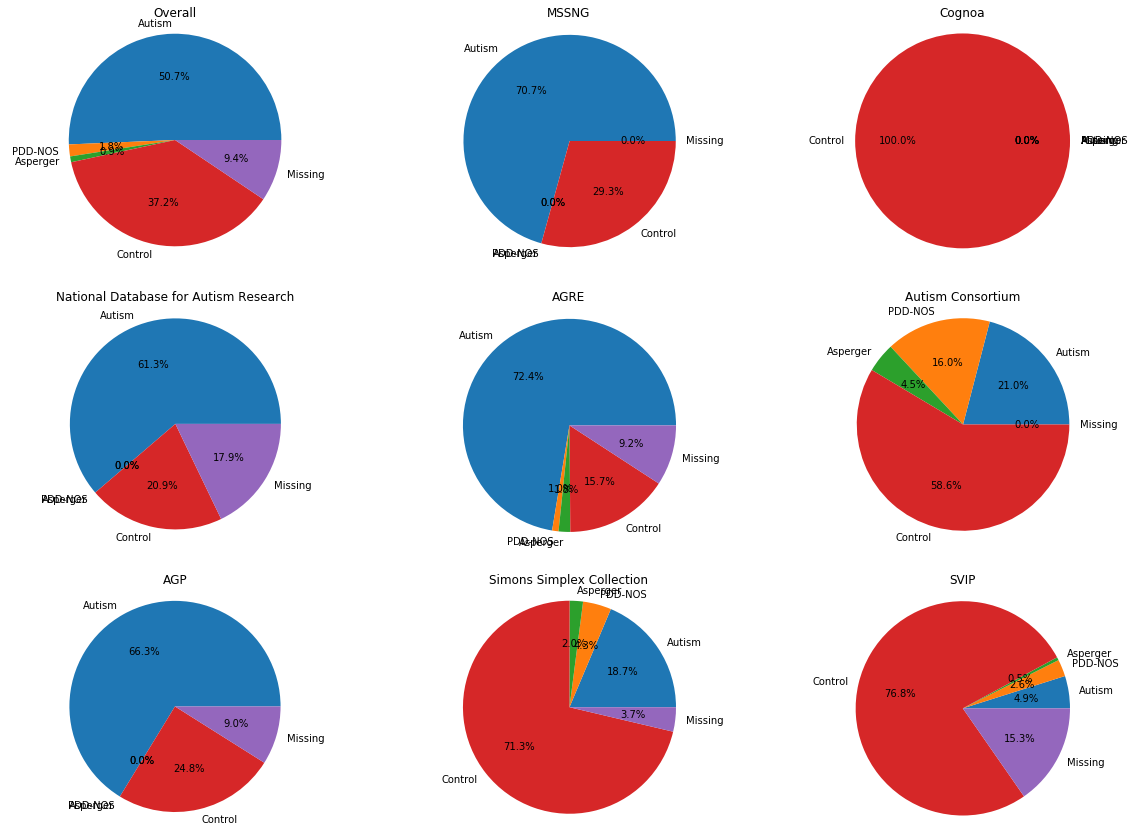

In [377]:
datasets = set([x[label_header.index('dataset')] for x in labels])
diag_dataset_c = Counter([(x[label_header.index('clinical_diagnosis')], x[label_header.index('dataset')]) for x in labels])
keys = ['Autism', 'PDD-NOS', 'Asperger', 'Control', 'None']

# overall
plt.figure(figsize=(20, 20))
plt.subplot(4, 3, 1)
plt.title('Overall')
c = Counter([x[label_header.index('clinical_diagnosis')] for x in labels])
plt.pie([c[k] for k in keys], labels=[k if k != 'None' else 'Missing' for k in keys], autopct='%1.1f%%')
plt.axis('equal')

for i, d in enumerate(datasets):
    plt.subplot(4, 3, i+2)
    plt.title(d)
    plt.pie([diag_dataset_c[(k, d)] for k in keys], labels=[k if k != 'None' else 'Missing' for k in keys], autopct='%1.1f%%')
    plt.axis('equal')

plt.show()



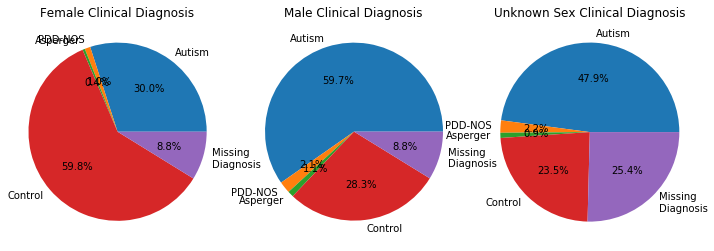

In [378]:
gender_diag_c = Counter([(x[label_header.index('gender')], x[label_header.index('clinical_diagnosis')]) for x in labels])

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.set_title('Female Clinical Diagnosis')
ax1.pie([gender_diag_c[('Female', k)] for k in clin_keys], labels=[k if k != 'None' else 'Missing\nDiagnosis' for k in clin_keys], autopct='%1.1f%%')
ax1.axis('equal')

ax2.set_title('Male Clinical Diagnosis')
ax2.pie([gender_diag_c[('Male', k)] for k in clin_keys], labels=[k if k != 'None' else 'Missing\nDiagnosis' for k in clin_keys], autopct='%1.1f%%')
ax2.axis('equal')

ax3.set_title('Unknown Sex Clinical Diagnosis')
ax3.pie([gender_diag_c[('None', k)] for k in clin_keys], labels=[k if k != 'None' else 'Missing\nDiagnosis' for k in clin_keys], autopct='%1.1f%%')
ax3.axis('equal')

plt.show()

## Dataset

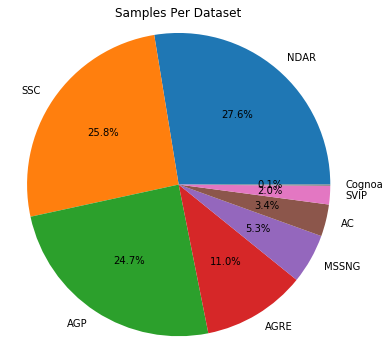

In [379]:
dataset_c = Counter([x[label_header.index('dataset')] for x in labels])
keys = list([k for k, v in dataset_c.most_common()])

abbrev = {'Autism Consortium': 'AC', 'Simons Simplex Collection': 'SSC', 'AGRE': 'AGRE', 'National Database for Autism Research': 'NDAR', 'Cognoa': 'Cognoa', 'SVIP': 'SVIP', 'AGP': 'AGP', 'MSSNG': 'MSSNG'}
fig1, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.pie([dataset_c[k] for k in keys], labels=[abbrev[k] for k in keys], autopct='%1.1f%%')
ax1.set_title('Samples Per Dataset')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


## Sex

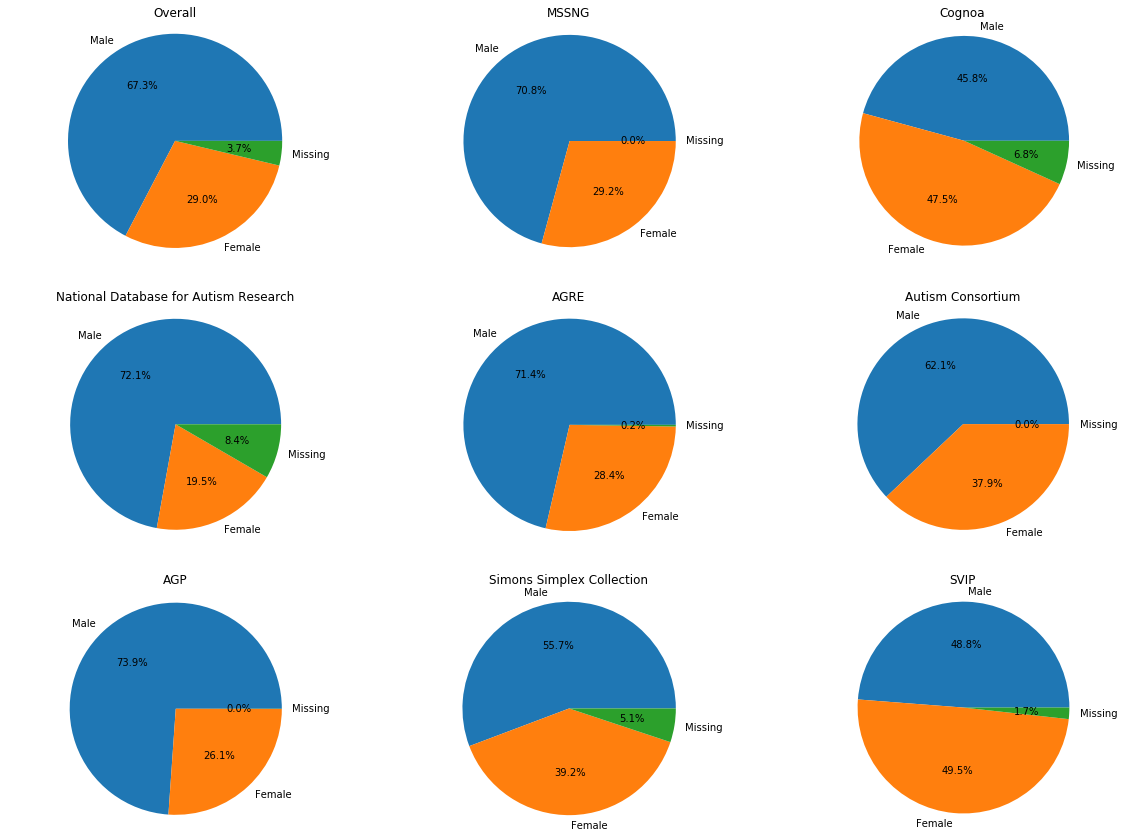

In [380]:
datasets = set([x[label_header.index('dataset')] for x in labels])
gender_dataset_c = Counter([(x[label_header.index('gender')], x[label_header.index('dataset')]) for x in labels])
keys = ['Male', 'Female', 'None']

# overall
plt.figure(figsize=(20, 20))
plt.subplot(4, 3, 1)
plt.title('Overall')
c = Counter([x[label_header.index('gender')] for x in labels])
plt.pie([c[k] for k in keys], labels=[k if k != 'None' else 'Missing' for k in keys], autopct='%1.1f%%')
plt.axis('equal')

for i, d in enumerate(datasets):
    plt.subplot(4, 3, i+2)
    plt.title(d)
    plt.pie([gender_dataset_c[(k, d)] for k in keys], labels=[k if k != 'None' else 'Missing' for k in keys], autopct='%1.1f%%')
    plt.axis('equal')

plt.show()



## Age

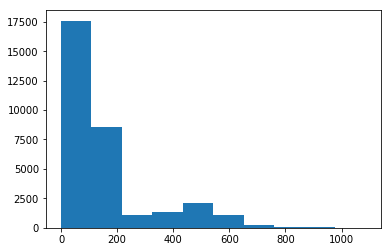

11544


In [386]:
plt.hist([int(x[label_header.index('age')]) for x in labels if x[label_header.index('age')] != 'None'])
plt.show()

print(len([x for x in labels if x[label_header.index('age')] == 'None']))

## Family

In [383]:
print('Missing families', len([x for x in labels if x[label_header.index('family')] == 'None']))
print('Missing mothers', len([x for x in labels if x[label_header.index('mother_id')] == 'None']))
print('Missing fathers', len([x for x in labels if x[label_header.index('father_id')] == 'None']))

Missing families 12582
Missing mothers 40543
Missing fathers 40543


## Demographics

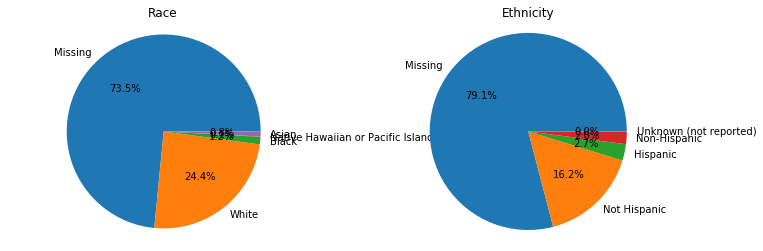

In [384]:
race_c = Counter([x[label_header.index('race')] for x in labels])
race_keys = race_c.keys()
ethnicity_c = Counter([x[label_header.index('ethnicity')] for x in labels])
ethnicity_keys = ethnicity_c.keys()

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.set_title('Race')
ax1.pie([race_c[k] for k in race_keys], labels=[k if k != 'None' else 'Missing' for k in race_keys], autopct='%1.1f%%')
ax1.axis('equal')

ax2.set_title('Ethnicity')
ax2.pie([ethnicity_c[k] for k in ethnicity_keys], labels=[k if k != 'None' else 'Missing' for k in ethnicity_keys], autopct='%1.1f%%')
ax2.axis('equal')

plt.show()

## Missing Data

(43684, 1013)
['ADIR1995', 'ADIR2003', 'ADIR2003_Toddler', 'ADOS2_Module1', 'ADOS2_Module2', 'ADOS2_Module3', 'ADOS2_Module4', 'ADOS2_Module_Toddler', 'ADOS_Module1', 'ADOS_Module2', 'ADOS_Module3', 'ADOS_Module4', 'SRS_Adult', 'SRS_Child', 'SRS_Preschool']


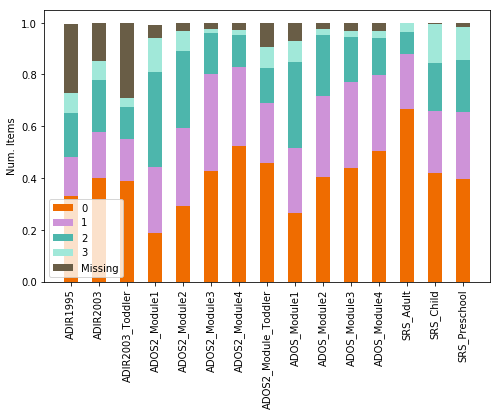

[('ADIR1995', 0.26651308740241847), ('ADIR2003', 0.1493367673725713), ('ADIR2003_Toddler', 0.28690446495385385), ('ADOS2_Module1', 0.051353874883286646), ('ADOS2_Module2', 0.032714412024756855), ('ADOS2_Module3', 0.024321172746959854), ('ADOS2_Module4', 0.026541095890410957), ('ADOS2_Module_Toddler', 0.09328125), ('ADOS_Module1', 0.0701086406943156), ('ADOS_Module2', 0.023898063262704147), ('ADOS_Module3', 0.030310792349726775), ('ADOS_Module4', 0.032216225262541316), ('SRS_Adult', 0.0016251751671729664), ('SRS_Child', 0.005932248934111999), ('SRS_Preschool', 0.0150997150997151)]


In [385]:
import numpy as np
from collections import defaultdict

print(data.shape)
instrument_to_indices = defaultdict(list)
for i, k in enumerate(header):
    if ':' in k:
        inst = k.split(':')[0]
        instrument_to_indices[inst].append(i)
        
inst_resp_to_count = dict()
for inst, indices in instrument_to_indices.items():
    inst_data = data[np.any(data[:, indices]>=0, axis=1), :][:, indices]
    unique, counts = np.unique(inst_data, return_counts=True)
    
    for k, v in zip(unique, counts):
        inst_resp_to_count[(inst, k)] = v/(inst_data.shape[0]*inst_data.shape[1])

instruments = sorted(instrument_to_indices.keys())
print(instruments)
ind = range(len(instruments))
width = 0.5

plt.figure(figsize=(8, 5))
total = [0]*len(instruments)
for i in range(4):
    r = [0 if (inst, i) not in inst_resp_to_count else inst_resp_to_count[(inst, i)] for inst in instruments]
    plt.bar(ind, r, width, color=colors[i+1], label=str(i), bottom=total)
    total = [t+s for t, s in zip(total, r)]
missing = [0 if (inst, -1) not in inst_resp_to_count else inst_resp_to_count[(inst, -1)] for inst in instruments]
plt.bar(ind, missing, width, color=colors[0], label='Missing', bottom=total)

plt.ylabel('Num. Items')

plt.xticks(ind, instruments, rotation='vertical')
plt.legend()
plt.show()

print(list(zip(instruments, missing)))

## Types of ADIR questions

In [15]:
from collections import defaultdict

datatype_to_q = defaultdict(set)

for key, value in pheno_schema['definitions']['ADIR']['properties'].items():
    if 'data-type' in value:
        if key.endswith('a'):
            datatype_to_q['categorical a'].add(key[:-1])
        elif '.' in key:
            datatype_to_q['ordinal double'].add(key.split('.')[0])
        else:
            datatype_to_q[value['data-type']].add(key)
        
for key, value in datatype_to_q.items():
    print(key, len(value), value, sep='\t')


score	16	{'social_interaction', 'restricted_repetitive_behavior', 'C1', 'A2', 'A1', 'communication', 'B3', 'C3', 'B1', 'B4', 'B2', 'C4', 'A4', 'C2', 'A3', 'abnormality_evident_before_3_years'}
interval	14	{'Q05', 'Q07', 'Q04', 'Q08', 'Q17', 'Q28', 'Q87', 'Q10', 'Q26', 'Q86', 'Q19', 'Q06', 'Q02', 'Q09'}
categorical a	145	{'Q16', 'Q44.2', 'Q83.1', 'Q46.1', 'Q79.2', 'Q17', 'Q55.2', 'Q10', 'Q52.1', 'Q51.1', 'Q58.1', 'Q68.2', 'Q64.1', 'Q34.2', 'Q85.2', 'Q60.1', 'Q32.2', 'Q33.1', 'Q45.1', 'Q71.1', 'Q62.2', 'Q81.1', 'Q40.2', 'Q84.2', 'Q42.1', 'Q48.2', 'Q90.2', 'Q62.1', 'Q67.2', 'Q54.1', 'Q47.1', 'Q69.1', 'Q49.2', 'Q61.2', 'Q47.2', 'Q69.2', 'Q39.1', 'Q56.2', 'Q09', 'Q05', 'Q74.2', 'Q63.1', 'Q08', 'Q43.1', 'Q53.2', 'Q57.1', 'Q66.1', 'Q41.2', 'Q84.1', 'Q78.1', 'Q67.1', 'Q63.2', 'Q36.1', 'Q85.1', 'Q91.2', 'Q06', 'Q71.2', 'Q73.2', 'Q44.1', 'Q70.2', 'Q92.1', 'Q68.1', 'Q61.1', 'Q88.2', 'Q37.2', 'Q29.2', 'Q33.2', 'Q26', 'Q54.2', 'Q76.2', 'Q60.2', 'Q13', 'Q90.1', 'Q86', 'Q19', 'Q50.1', 'Q35.2', 'Q59.1

## Types of ADOS questions

In [16]:
from collections import defaultdict

datatype_to_q = defaultdict(set)

for key, value in pheno_schema['definitions']['ADOS']['properties'].items():
    if 'data-type' in value:
        if key.endswith('a'):
            datatype_to_q['categorical a'].add(key[:-1])
        elif '.' in key:
            datatype_to_q['ordinal double'].add(key.split('.')[0])
        else:
            datatype_to_q[value['data-type']].add(key)
        
for key, value in datatype_to_q.items():
    print(key, len(value), value, sep='\t')


score	3	{'social_interaction', 'restricted_repetitive_behavior', 'communication'}
ordinal	46	{'QB17', 'QA03', 'QB05', 'QD03', 'QB02', 'QA01', 'QB09', 'QB12', 'QA06', 'QD01', 'QB06', 'QA10', 'QB18', 'QB08', 'QC02', 'QA09', 'QB23', 'QB13', 'QB03', 'QC01', 'QB07', 'QA04', 'QA05', 'QA13', 'QD04', 'QB04', 'QB16', 'QA08', 'QA12', 'QE01', 'QA07', 'QB10', 'QB01', 'QB19', 'QA11', 'QB14', 'QB22', 'QB15', 'QB21', 'QD05', 'QA02', 'QE03', 'QB20', 'QB11', 'QE02', 'QD02'}


In [17]:
feature_mapping = {
	'ADOS_Module1': {
		"QA01": "QA01", "QA02": "QA11", "QA03": "QA02", "QA04": "QA03", "QA05": "QA04", 
		"QA06": "QA12", "QA07": "QA07", "QA08": "QA10",
		"QB01": "QB01", "QB02": "QB17", "QB03": "QB02", "QB04": "QB16", "QB05": "QB04",
		"QB06": "QB07", "QB07": "QB19", "QB08": "QB21", "QB09": "QB08", "QB10": "QB10", 
		"QB11": "QB09", "QB12": "QB13", "QB13.1": "QB11", "QB13.2": "QB23", "QB14": "QB14", "QB15": "QB22",
		"QB16": "QB15",
		"QC01": "QC01", "QC02": "QC02",
		"QD01": "QD01", "QD02": "QD02", "QD03": "QD03", "QD04": "QD04",
		"QE01": "QE01", "QE02": "QE02", "QE03": "QE03"
	},
	'ADOS_Module2': {
		"QA01": "QA01", "QA02": "QA02", "QA03": "QA03", "QA04": "QA04", "QA05": "QA09",
		"QA06": "QA07", "QA07": "QA10",
		"QB01": "QB01", "QB02": "QB02", "QB03": "QB04", "QB04": "QB07", "QB05": "QB08",
		"QB06": "QB10", "QB07": "QB09", "QB08": "QB13", "QB09.1": "QB11", "QB09.2": "QB23", "QB10": "QB14",
		"QB11": "QB12", "QB12": "QB15", 
		"QC01": "QC01", "QC02": "QC02",
		"QD01": "QD01", "QD02": "QD02", "QD03": "QD03", "QD04": "QD04",
		"QE01": "QE01", "QE02": "QE02", "QE03": "QE03"
	},
	'ADOS_Module3': {
		"QA01": "QA01", "QA02": "QA02", "QA03": "QA03", "QA04": "QA04", "QA05": "QA05", 
		"QA06": "QA06", "QA07": "QA08", "QA08": "QA09", "QA09": "QA10",
		"QB01": "QB01", "QB02": "QB02", "QB03": "QB03", "QB04": "QB04", "QB05": "QB05",
		"QB06": "QB06", "QB07": "QB13", "QB08": "QB11", "QB09": "QB14", "QB10": "QB12",
		"QB11": "QB15",
		"QC01": "QC02",
		"QD01": "QD01", "QD02": "QD02", "QD03": "QD03", "QD04": "QD04", "QD05": "QD05",
		"QE01": "QE01", "QE02": "QE02", "QE03": "QE03"

	},
	'ADOS_Module4': {
		"QA01": "QA01", "QA02": "QA02", "QA03": "QA03", "QA04": "QA04", "QA05": "QA05", 
		"QA06": "QA06", "QA07": "QA08", "QA08": "QA09", "QA09": "QA10", "QA10": "QA13",
		"QB01": "QB01", "QB02": "QB02", "QB03": "QB03", "QB04": "QB04", "QB05": "QB18",
		"QB06": "QB05", "QB07": "QB06", "QB08": "QB20", "QB09": "QB13", "QB10": "QB11",
		"QB11": "QB14", "QB12": "QB12", "QB13": "QB15",
		"QC01": "QC02",
		"QD01": "QD01", "QD02": "QD02", "QD03": "QD03", "QD04": "QD04", "QD05": "QD05",
		"QE01": "QE01", "QE02": "QE02", "QE03": "QE03"
	}
}

agg_mod_to_mods = defaultdict(dict)

for module in feature_mapping.keys():
    for key, value in feature_mapping[module].items():
        agg_mod_to_mods[value][module] = key

for key in sorted(agg_mod_to_mods.keys()):
    values = agg_mod_to_mods[key]
    print(key, '' if 'ADOS_Module1' not in values else values['ADOS_Module1'],
         '' if 'ADOS_Module2' not in values else values['ADOS_Module2'],
         '' if 'ADOS_Module3' not in values else values['ADOS_Module3'],
         ('' if 'ADOS_Module4' not in values else values['ADOS_Module4']) + '\\\\', sep=' & ')


QA01 & QA01 & QA01 & QA01 & QA01\\
QA02 & QA03 & QA02 & QA02 & QA02\\
QA03 & QA04 & QA03 & QA03 & QA03\\
QA04 & QA05 & QA04 & QA04 & QA04\\
QA05 &  &  & QA05 & QA05\\
QA06 &  &  & QA06 & QA06\\
QA07 & QA07 & QA06 &  & \\
QA08 &  &  & QA07 & QA07\\
QA09 &  & QA05 & QA08 & QA08\\
QA10 & QA08 & QA07 & QA09 & QA09\\
QA11 & QA02 &  &  & \\
QA12 & QA06 &  &  & \\
QA13 &  &  &  & QA10\\
QB01 & QB01 & QB01 & QB01 & QB01\\
QB02 & QB03 & QB02 & QB02 & QB02\\
QB03 &  &  & QB03 & QB03\\
QB04 & QB05 & QB03 & QB04 & QB04\\
QB05 &  &  & QB05 & QB06\\
QB06 &  &  & QB06 & QB07\\
QB07 & QB06 & QB04 &  & \\
QB08 & QB09 & QB05 &  & \\
QB09 & QB11 & QB07 &  & \\
QB10 & QB10 & QB06 &  & \\
QB11 & QB13.1 & QB09.1 & QB08 & QB10\\
QB12 &  & QB11 & QB10 & QB12\\
QB13 & QB12 & QB08 & QB07 & QB09\\
QB14 & QB14 & QB10 & QB09 & QB11\\
QB15 & QB16 & QB12 & QB11 & QB13\\
QB16 & QB04 &  &  & \\
QB17 & QB02 &  &  & \\
QB18 &  &  &  & QB05\\
QB19 & QB07 &  &  & \\
QB20 &  &  &  & QB08\\
QB21 & QB08 &  &  & \\
QB22 & QB1

## Types of SRS questions

In [18]:
from collections import defaultdict

datatype_to_q = defaultdict(set)

for key, value in pheno_schema['definitions']['SRS']['properties'].items():
    if 'data-type' in value:
        if key.endswith('a'):
            datatype_to_q['categorical a'].add(key[:-1])
        elif '.' in key:
            datatype_to_q['ordinal double'].add(key.split('.')[0])
        else:
            datatype_to_q[value['data-type']].add(key)
        
for key, value in datatype_to_q.items():
    print(key, len(value), value, sep='\t')


score	7	{'social_communication', 'social_awareness', 'autistic_mannerisms', 'social_cognition', 'social_motivation', 'total_t_score', 'total_raw_score'}
ordinal	65	{'Q01', 'Q05', 'Q16', 'Q07', 'Q59', 'Q08', 'Q17', 'Q28', 'Q10', 'Q40', 'Q56', 'Q57', 'Q03', 'Q12', 'Q64', 'Q36', 'Q25', 'Q47', 'Q39', 'Q60', 'Q04', 'Q35', 'Q53', 'Q11', 'Q31', 'Q63', 'Q27', 'Q45', 'Q34', 'Q65', 'Q06', 'Q62', 'Q23', 'Q02', 'Q29', 'Q42', 'Q21', 'Q51', 'Q14', 'Q24', 'Q26', 'Q33', 'Q43', 'Q30', 'Q32', 'Q61', 'Q52', 'Q55', 'Q37', 'Q13', 'Q22', 'Q49', 'Q20', 'Q18', 'Q15', 'Q48', 'Q44', 'Q19', 'Q41', 'Q50', 'Q54', 'Q46', 'Q58', 'Q38', 'Q09'}
